[View in Colaboratory](https://colab.research.google.com/github/andersy005/video-game-graphics-to-reality-and-back/blob/master/notebooks/image_translation.ipynb)

# Install Colaboratory Tools

In [1]:
!pip uninstall colabtools -y

Uninstalling colabtools-0.0.1:
  Successfully uninstalled colabtools-0.0.1


In [0]:
!pip install git+https://github.com/andersy005/colaboratory-tools.git --no-cache-dir

# Load Data

Check to see if the data is already available. If not, download the data from google drive and extract the files from compressed files.

In [0]:
%%bash
if [ ! -f gta.tar.gz ]; then
  echo "File not found!"
 
  wget --header 'Host: doc-0s-58-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:59.0) Gecko/20100101 Firefox/59.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://drive.google.com/drive/u/1/folders/1B56WZ20ODejt7MAwFr0a2HnMJ0fz4VlN' --header 'Cookie: AUTH_e1273drrbkihn7uunefac5g2nh6fppao_nonce=dmk22oppc7sqq; NID=123=lBPWjtG4k1sU7Dd0qsq5jpbqEiDrMBU8x0r6kdqXBCf-pCwxt9y7UdTTVaEFzLR7u5w-wq6dp0xKDTIsDb6QCnL0jNICERWUAuRHrxjQlpzo8gI8bqEpJJBDhN1T2RNR' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-0s-58-docs.googleusercontent.com/docs/securesc/u8k4a259k8v0rijo1dv2q4t69g74544s/dfhbmn3d102hjss1cklgsjkrg3lv8a9r/1523498400000/07610261954870412584/07610261954870412584/1K-iCnC8Io_libKnOj4qsygIBuckMfZ6b?e=download&h=11006290462901738094&nonce=dmk22oppc7sqq&user=07610261954870412584&hash=8kg9rnfhe21nv5cot61mpq0qipleelt3' --output-document 'city.tar.gz' -c
  wget --header 'Host: doc-0g-58-docs.googleusercontent.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:59.0) Gecko/20100101 Firefox/59.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://drive.google.com/drive/u/1/folders/1B56WZ20ODejt7MAwFr0a2HnMJ0fz4VlN' --header 'Cookie: AUTH_e1273drrbkihn7uunefac5g2nh6fppao=07610261954870412584|1523498400000|sjllo7r1m2oq1rq17912blpr79i1df9q; NID=123=lBPWjtG4k1sU7Dd0qsq5jpbqEiDrMBU8x0r6kdqXBCf-pCwxt9y7UdTTVaEFzLR7u5w-wq6dp0xKDTIsDb6QCnL0jNICERWUAuRHrxjQlpzo8gI8bqEpJJBDhN1T2RNR' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' 'https://doc-0g-58-docs.googleusercontent.com/docs/securesc/u8k4a259k8v0rijo1dv2q4t69g74544s/3e1lpingoh7ccl9b201sel1lj89khf7v/1523498400000/07610261954870412584/07610261954870412584/1uzs0CEEVbihK0n2fjVjky4-X8vBl1LSt?h=11006290462901738094&e=download' --output-document 'gta.tar.gz' -c
  tar -zxvf city.tar.gz
  tar -zxvf gta.tar.gz
 
fi

In [0]:
import matplotlib.pyplot as plt
#%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8)

from colabtools.pytorch import datasets as cds
from torch import utils
from torchvision import transforms

In [0]:
compose = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            #transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
gta = cds.CustomDataset(root_dir='./gta/images/', transform=compose)
gta_loader = utils.data.DataLoader(gta, num_workers=4, shuffle=True, 
                                   batch_size=4)
city = cds.CustomDataset(root_dir='./city_real/', transform=compose)
city_loader = utils.data.DataLoader(city, num_workers=4, shuffle=True,
                                   batch_size=4)

def show_images(loader):
  for i_batch, sample_batched in enumerate(loader):
    print(i_batch, sample_batched.size())

    if i_batch == 3:
      cds.show_batch(sample_batched)
      plt.show()
      break

# Plot some images from both datasets

0 torch.Size([4, 3, 256, 256])
1 torch.Size([4, 3, 256, 256])
2 torch.Size([4, 3, 256, 256])
3 torch.Size([4, 3, 256, 256])


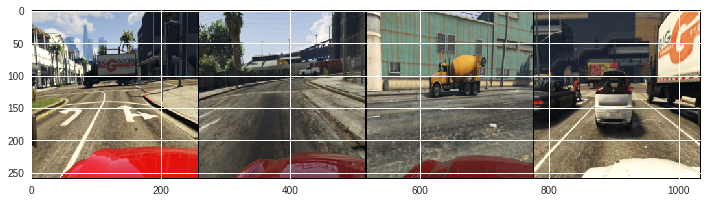

In [6]:

show_images(gta_loader)

0 torch.Size([4, 3, 256, 256])
1 torch.Size([4, 3, 256, 256])
2 torch.Size([4, 3, 256, 256])
3 torch.Size([4, 3, 256, 256])


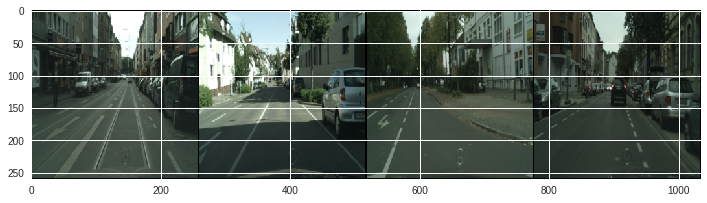

In [7]:

show_images(city_loader)

# Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch

In [0]:
class GenerativeNet12(torch.nn.Module):
    def __init__(self, c_out=64):
        super(GenerativeNet12, self).__init__()

        # Encoding blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=c_out,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=c_out,
                out_channels=c_out * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out * 2),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        # Residual blocks
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=c_out * 2,
                out_channels=c_out * 2,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out * 2),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=c_out * 2,
                out_channels=c_out * 2,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out * 2),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        # Decoding blocks
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=c_out * 2,
                out_channels=c_out,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=c_out,
                out_channels=3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.LeakyReLU(negative_slope=0.05, inplace=True))
        self.out = nn.Tanh()

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.deconv1(x)
        x = self.deconv2(x)

        # Apply Tanh
        return self.out(x)
    
    
class GenerativeNet21(torch.nn.Module):
    def __init__(self, c_out=64):
        super(GenerativeNet21, self).__init__()

        # Encoding blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=c_out,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=c_out,
                out_channels=c_out * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out * 2),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        # Residual blocks
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=c_out * 2,
                out_channels=c_out * 2,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out * 2),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=c_out * 2,
                out_channels=c_out * 2,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out * 2),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        # Decoding blocks
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=c_out * 2,
                out_channels=c_out,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=c_out,
                out_channels=3,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.LeakyReLU(negative_slope=0.05, inplace=True))
        self.out = nn.Tanh()

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.deconv1(x)
        x = self.deconv2(x)

        # Apply Tanh
        return self.out(x)

In [0]:
class DiscriminativeNet1(torch.nn.Module):
    def __init__(self, c_out=64):
        super(DiscriminativeNet1, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=c_out,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.LeakyReLU(negative_slope=0.05, inplace=True))

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=c_out,
                out_channels=c_out * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out * 2),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=c_out * 2,
                out_channels=c_out * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out * 4),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        self.fc = nn.Sequential(
            nn.Conv2d(
                in_channels=c_out * 4,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x).squeeze()
        return x 
    
class DiscriminativeNet2(torch.nn.Module):
    def __init__(self, c_out=64):
        super(DiscriminativeNet2, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=c_out,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.LeakyReLU(negative_slope=0.05, inplace=True))

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=c_out,
                out_channels=c_out * 2,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out * 2),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=c_out * 2,
                out_channels=c_out * 4,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False), nn.BatchNorm2d(c_out * 4),
            nn.LeakyReLU(negative_slope=0.05, inplace=True))

        self.fc = nn.Sequential(
            nn.Conv2d(
                in_channels=c_out * 4,
                out_channels=1,
                kernel_size=4,
                stride=1,
                padding=0,
                bias=False))
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x).squeeze()
        return x 

In [0]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [0]:
# Create Network instances and init weights
generator12 = GenerativeNet12()
generator12.apply(init_weights)
generator21= GenerativeNet21()
generator21.apply(init_weights)
discriminator1 = DiscriminativeNet1()
discriminator1.apply(init_weights)
discriminator2 = DiscriminativeNet2()
discriminator2.apply(init_weights)


# Enable cuda if available
if torch.cuda.is_available():
    generator12.cuda()
    generator21.cuda()
    discriminator1.cuda()
    discriminator2.cuda()

# Optimization

In [0]:
# Optimizers
g_params = list(generator12.parameters()) + list(generator21.parameters())
d_params = list(discriminator1.parameters()) + list(discriminator2.parameters())

d_optimizer = torch.optim.Adam(d_params, lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(g_params, lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

# Number of epochs
num_epochs = 200

# Training

In [0]:
def to_var(x):
  """ Converts numpy to Variable """
  if torch.cuda.is_available():
    x = x.cuda()
    return torch.autograd.Variable(x)
  
def to_var(x)
  

In [0]:
def train_discriminator1(optimizer, city_data, gta_data):
  # Reset gradients
  optimizer.zero_grad()
  
  # 1.1 Train on real images
  prediction_real_city = discriminator1(city_data)
  
  # Calculate error and backpropagate
  error_real_city = loss(prediction_real_city, )